In [ ]:
%%capture
!pip install optuna

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

%matplotlib inline
from sklearn.model_selection import GridSearchCV
# Модели из sklearn
from xgboost import XGBClassifier
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model Evaluations
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

## Load data

In [ ]:
df = pd.read_csv("/content/heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [ ]:
df.shape

(1025, 14)

## Построить и оценить качество бейзлайна

In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
# Split data into X and Y
X = df.drop('target', axis=1)

y = df['target']

## Произведено разбиение датасета на тернировочную/тестовую выборки

In [ ]:
# Разделите набор на обучающий и тестовый набор и установите случайное состояние на 42.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Бейзлайновая модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть

In [ ]:
# Помещаем модели в словарь
models = {"XGBoost": XGBClassifier(),
          "Logistic Regression": LogisticRegression(random_state=42)
          }

# Мы создаем функцию для подбора и оценки моделей
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """Соответствует и оценивает заданные модели машинного обучения.
    Параметры:
    модели: список различных моделей машинного обучения Scikit-Learn.
    X_train: данные обучения (без меток)
    X_test: данные тестирования (без меток)
    y_train: данные обучения
    y_test: данные тестирования

    Возврат:
    Словарь моделей и их оценок
    """
    # Создать словарь для хранения оценок моделей.
    model_scores = {}

    # LПеребирать модели
    for name, model in models.items():
        if name == "XGBoost":
          np.random.seed(42)
        # Подогнать модель к данным
        model.fit(X_train, y_train)
        # Оценить модель и добавить ее оценку в словарь model_scores.
        model_scores[name] = model.score(X_test, y_test)

    return model_scores

In [ ]:
model_scores = fit_and_score(models=models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_scores

{'XGBoost': 0.9853658536585366, 'Logistic Regression': 0.7853658536585366}

## Выбрана более сложная ML-модель

Мы будем использовать здесь логистическую регрессию. Модели, использованные в предыдущем задании, уже имеют очень хорошие оценки и очень мало возможностей для улучшения. Даже XGBoost имеет хорошие оценки. Поэтому для этой задачи мы выбрали логистическую регрессию.

## Произведен подбор гиперпараметров с scikit-learn методами на кросс-валидации

In [ ]:
# Произведен подбор гиперпараметров с scikit-learn методами на кросс-валидации

# Create a GridSearchCV object.
grid_search = GridSearchCV(models["Logistic Regression"],
                          param_grid={"C": [0.001, 0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "newton-cg", "sag", "saga"], "max_iter": [100, 500, 1000, 2000, 5000]},
                          cv=5)
# Fit the GridSearchCV object to the data.
grid_search.fit(X_train, y_train)


In [ ]:
# Print the best hyperparameters and score.
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best hyperparameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Best score: 0.853658536585366


In [ ]:
cv_results = cross_val_score(grid_search, X_train, y_train, cv=5, scoring='f1')

In [ ]:
cv_results

array([0.8372093 , 0.86666667, 0.9047619 , 0.87912088, 0.81318681])

In [ ]:
print(f"Cross-Validation F1_score: {cv_results.mean():.4f} (+/- {cv_results.std():.4f})")

Cross-Validation F1_score: 0.8602 (+/- 0.0320)


## Произведен подбор гиперпараметров с optuna на кросс-валидации

In [ ]:
# Произведен подбор гиперпараметров с optuna на кросс-валидации

# Создайте функцию для оценки модели.
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает модель машинного обучения.
    Параметры:
    model: модель машинного обучения Scikit-Learn.
    X_train: данные обучения (без меток)
    y_train: данные обучения
    X_test: данные тестирования (без меток)
    y_test: данные тестирования

    Возврат:
    Оценка модели
    """
    # Подогнать модель к данным.
    model.fit(X_train, y_train)

    # Оценить модель.
    score = model.score(X_test, y_test)

    return score


def optimize_hyperparameters(model, X_train, y_train, X_test, y_test):
    """Оптимизирует гиперпараметры модели машинного обучения.
    Параметры:
    model: модель машинного обучения Scikit-Learn.
    X_train: данные обучения (без меток)
    y_train: данные обучения
    X_test: данные тестирования (без меток)
    y_test: данные тестирования

    Возврат:
    Оптимизированная модель
    """
    study = optuna.create_study(direction="maximize")

    def objective(trial):
        """Определяет объективную функцию для оптимизации гиперпараметров.
        Параметры:
        trial: объект Optuna Trial.

        Возврат:
        Оценка модели
        """
        hyperparameters = {
            "C": trial.suggest_loguniform("C", 1e-5, 1e5),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "newton-cg", "sag", "saga"]),
            "max_iter": trial.suggest_int("max_iter", 100, 5000),
        }

        model.set_params(**hyperparameters)

        score = evaluate_model(model, X_train, y_train, X_test, y_test)

        return score

    study.optimize(objective, n_trials=100)

    best_hyperparameters = study.best_params

    best_model = model.set_params(**best_hyperparameters)

    return best_model

best_model = optimize_hyperparameters(LogisticRegression(random_state=42), X_train, y_train, X_test, y_test)

In [ ]:
cv_results_optuna = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')

In [ ]:
cv_results_optuna

array([0.84210526, 0.86666667, 0.89411765, 0.87912088, 0.81967213])

In [ ]:
print(f"Cross-Validation F1_score optuna: {cv_results_optuna.mean():.4f} (+/- {cv_results_optuna.std():.4f})")

Cross-Validation F1_score optuna: 0.8603 (+/- 0.0265)


In [ ]:
# Print the best hyperparameters.
print(f"Best hyperparameters using Optuna: {best_model.get_params()}")

# Print the score of the best model.
print(f"Score of the best model Optuna: {evaluate_model(best_model, X_train, y_train, X_test, y_test)}")

Best hyperparameters using Optuna: {'C': 99.02634403053248, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2825, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Score of the best model Optuna: 0.7951219512195122


## Выбранная модель обучена с лучшими подобранными значениями гиперпараметров

In [ ]:
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best hyperparameters: {'C': 10, 'max_iter': 100, 'solver': 'lbfgs'}
Best score: 0.853658536585366


## Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики

In [ ]:
# Evaluate the model on the test set.
y_pred = best_model.predict(X_test)

# Calculate the f1 score.
f1_score(y_test, y_pred)

0.8235294117647058

## Получена интерпретация построенной модели, включая визуализации (коэффициенты/permutation importances/shap и тд)

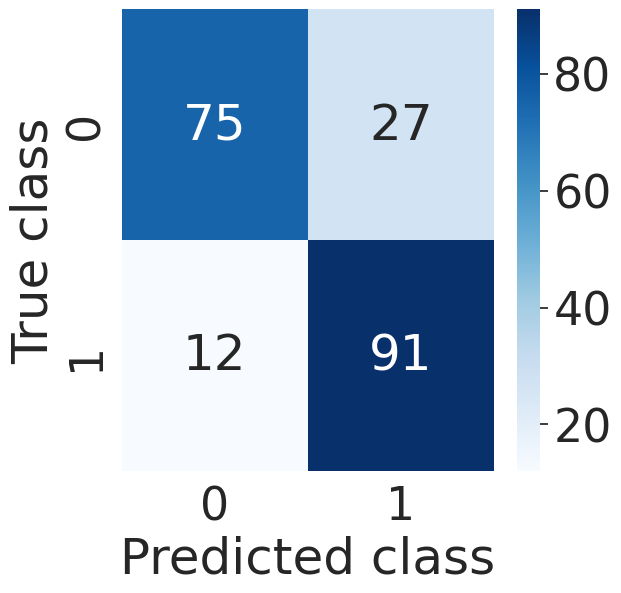

In [146]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

Строки: Представляют собой реальные классы точек данных.

Столбцы: Представляют предсказанные моделью классы.

Ячейки: Указывают количество точек данных, которые попадают в каждую комбинацию фактических и предсказанных классов.

False Negatives (FN) = 12 ==> количество фактических положительных случаев, ошибочно определенных моделью как отрицательные.

True Positives (TP) = 91 ==> количество фактических положительных случаев, правильно определенных моделью как положительные.

False Positives (FP) = 27 ==> количество фактических отрицательных случаев, ошибочно определенных моделью как положительные.

True Negatives (TN): 75 ==>  количество фактических отрицательных случаев, правильно определенных моделью как отрицательные.

In [145]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.74      0.79       102
           1       0.77      0.88      0.82       103

    accuracy                           0.81       205
   macro avg       0.82      0.81      0.81       205
weighted avg       0.82      0.81      0.81       205



In [ ]:
def get_feature_importances_logistic_regression(model, feature_names):
    """Рассчитывает важность функций для модели логистической регрессии.

    Аргументы:
        модель: обученная модель логистической регрессии.
        Feature_names: список имен функций, соответствующих функциям модели.

    Возврат:
        Список кортежей, где каждый кортеж содержит имя функции и ее оценку важности.
    """

    if not hasattr(model, 'coef_'):
        raise ValueError("Model does not have 'coef_' attribute. Check model type.")

    importances = abs(model.coef_[0])
    feature_importances = [(feature_names[i], importance) for i, importance in enumerate(importances)]
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    return feature_importances

In [ ]:
feature_names = list(X_train.columns)

In [ ]:
feature_importances = get_feature_importances_logistic_regression(best_model, feature_names)

print("Feature importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance:.4f}")

Feature importances:
sex: 1.7534
thal: 1.0387
cp: 0.8636
ca: 0.8253
exang: 0.7915
oldpeak: 0.6331
slope: 0.6188
restecg: 0.4006
fbs: 0.2600
thalach: 0.0366
age: 0.0163
trestbps: 0.0152
chol: 0.0082


In [ ]:
def plot_feature_importances(feature_importances, feature_names):
    """Plots feature importances for a Logistic Regression model.

    Args:
        feature_importances: A list of tuples, where each tuple contains the feature name and its importance score.
        feature_names: A list of feature names corresponding to the model's features.

    Returns:
        None
    """

    # Sort the features by importance.
    feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

    # Create a bar plot of the feature importances.
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importances)), [importance[1] for importance in feature_importances],
            color="b", align="center")
    plt.xticks(range(len(feature_importances)), [importance[0] for importance in feature_importances])
    plt.title("Feature importances")
    plt.show()

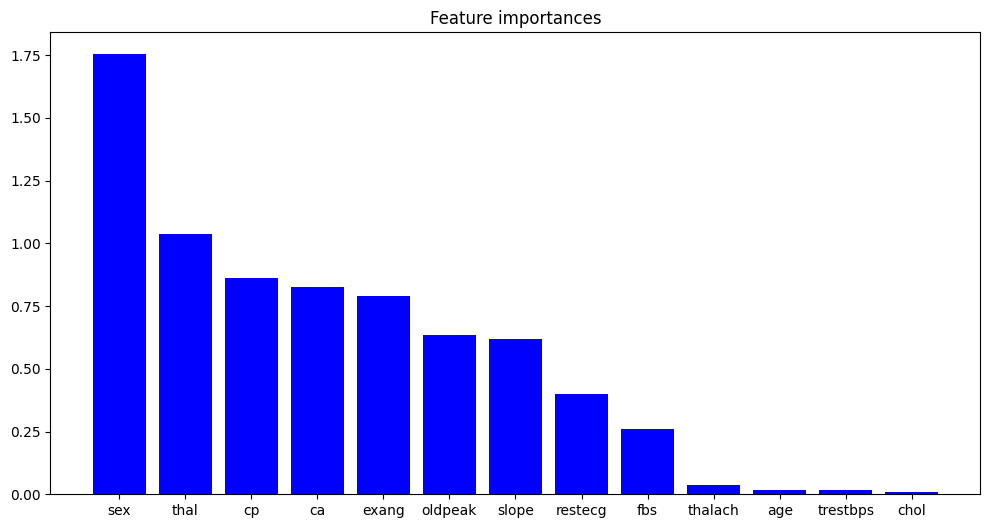

In [ ]:
plot_feature_importances(feature_importances, feature_names)

## Ключевые выводы:

Наиболее важные признаки:

* sex (1.7534)
* thal (1.0387)
* cp (0.8636)
* ca (0.8253)
* exang (0.7915)

Эти признаки оказывают наибольшее влияние на прогнозы модели.
Наименее важные признаки:

* thalach (0.0366)
* age (0.0163)
* trestbps (0.0152)
* chol (0.0082) Влияние этих признаков на прогнозы модели минимально.

## Приведено экспертное мнение о полученной интерпретации (вы, как эксперт в предметной области, можете оценить адекватность признаков и решений, принимаемых моделью, и выразить свое мнение в 1-2 предложении) - 4 баллов

Логистическая регрессия хорошо подходит для задач бинарной классификации, цель которых — предсказать один из двух возможных результатов. Он моделирует вероятность принадлежности к определенному классу и предоставляет интерпретируемые коэффициенты. Другие полезные алгоритмы классификации включают деревья решений, случайные леса, машины опорных векторов (SVM), k-ближайшие соседи (k-NN) и методы повышения градиента, такие как XGBoost или LightGBM, каждый из которых имеет свои сильные стороны и подходит для разных типов наборов данных.

**Дополнительные выводы:**

Пол: Является наиболее важным признаком, что указывает на значительную разницу в результатах прогноза в зависимости от пола.
Таллий: Второй по важности, вероятно, указывает на важность результатов сцинтиграфии с таллием для прогноза.
Боль в груди (cp), Основные сосуды (ca), Стенокардия напряжения (exang): Также очень важны, что указывает на их связь с целевой переменной.